In [970]:
import os
from fastai.data.external import untar_data, URLs
import resnet

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Скачиваем датасет CIFAR10

In [971]:


dataset = torchvision.datasets.CIFAR10(root='./data', download=True)

Files already downloaded and verified


In [972]:

stats = ((0.5, 0.5, 0.5), (0.3, 0.3, 0.3))
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize(*stats,inplace=True)])

In [973]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

batch_size = 100
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size * 2, num_workers=2, pin_memory=True)

In [974]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
print(device)

trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

cuda


In [975]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [976]:
class ImageClassificationBase:
    def __init__(self, model: nn.Module, name: str):
        """
        Initialize the model.

        Args:
            model: PyTorch model
            name: Name identifier for the model
        """
        self.model = model.to(device)
        self.name = name
        
    def training_step(self, batch):
        images, labels = batch 
        out = self.model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self.model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc']))

Создадим папку, чтобы сохранить нашу модель

In [977]:
MODEL_PATH = "models/"
MODEL_EXP_PATH = MODEL_PATH + "bestAcc/"
try:
    os.mkdir(MODEL_PATH)
except:
    print("Folder already exists")

try:
    os.mkdir(MODEL_EXP_PATH)
except:
    print("Folder already exists")

Folder already exists
Folder already exists


Функции тренировки и тестирования

In [978]:
import torch.optim as optim
@torch.no_grad()
def evaluate(model, val_loader):
    net = model.model
    net.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, model, train_loader, val_loader, learning_rate):
    history = []
    optimizer = torch.optim.SGD(model.model.parameters(), lr = learning_rate, momentum=0.9)
    best_accuracy=0.0
    best_train_loss = 100
    all_predictions = 0
    correct_predictions = 0
    for epoch in range(epochs):
        # Training Phase 
        model.model.train()
        train_losses = []
        train_accuracy= []
        running_loss = 0.0
        for (batch_idx, batch) in enumerate(train_loader):
            optimizer.zero_grad()

            loss, accuracy = model.training_step(batch)

            train_losses.append(loss)
            train_accuracy.append(accuracy)

            loss.backward()
            optimizer.step()
            
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if result['val_acc']>best_accuracy:
            best_accuracy=result['val_acc']
            torch.save(model.model.state_dict(), MODEL_EXP_PATH + "/baseline_"+ model.name +"_accuracy")

        if result['val_loss']<best_train_loss:
            best_train_loss = result['val_loss']
            torch.save(model.model.state_dict(), MODEL_EXP_PATH + "/baseline_"+ model.name +"_loss")
    return history

Функции для постройки графиков изменения точности и потерь моделей

In [979]:
def plot_accuracies(history, model_name):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title("Accuracy of " + model_name)

In [980]:
def plot_losses(history, model_name):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title("Losses of " + model_name)

Модифицируем AlexNet

In [981]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)

            
        )
        self.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.AdaptiveAvgPool2d(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Модификация встроенной модели ResNext50_32x4d

In [982]:
class ResNext50(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.resnext50_32x4d(weights = models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        super().__init__(model, "resNext50")
class ResNext50Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.resnext50_32x4d(weights = models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False
        
        for param in model.fc.parameters():
            param.requires_grad = True
        
        super().__init__(model, "resNext50_mods")

Модификация встроенной модели mobilenet_v2

In [983]:
class MobileNetV2(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.mobilenet_v2(weights = models.MobileNet_V2_Weights.IMAGENET1K_V2)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        super().__init__(model, "mobilenet_v2")

class MobileNetV2Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.mobilenet_v2(weights = models.MobileNet_V2_Weights.IMAGENET1K_V2)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.features[:2].parameters():
            param.requires_grad = True
        for param in model.features[-2:].parameters():
            param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True
        
        super().__init__(model, "mobilenet_v2")

Модификация встроенной модели shufflenet_v2_x1_0

In [984]:
class ShuffleNetV2(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.shufflenet_v2_x1_0(weights = models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        super().__init__(model, "shufflenet_v2")

class ShuffleNetV2Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.shufflenet_v2_x1_0(weights = models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False

        for param in model.fc.parameters():
            param.requires_grad = True
        
        super().__init__(model, "shufflenet_v2")

Добавим 3 встроенные модели библиотеки pytorch и создадим их

In [985]:
# alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_net.eval()

# inception_net = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
# inception_net.eval()

# res_next50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
# res_next50.eval()
# shuffle_netv2 = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
# shuffle_netv2 .eval()

alex_net = ImageClassificationBase(AlexNet(), "alexNet")
res_next50 = ResNext50(10)
mobile_net = MobileNetV2(10)
shuffle_net = ShuffleNetV2(10)
from torchinfo import summary

#summary(alex_net, input_size=(batch_size, 3, 32, 32))
#summary(mobile_net, input_size=(batch_size, 3, 32, 32))
#summary(res_next50, input_size=(batch_size, 3, 32, 32))
#summary(shuffle_net, input_size=(batch_size, 3, 32, 32))



Параметры обучения

In [986]:
epochs = 10
lr = 0.001

Тренировка моделей без модификаций

ResNext50

Epoch [1], train_loss: 1.6723, train_acc: 0.4064, val_loss: 1.3608, val_acc: 0.6059
Epoch [2], train_loss: 0.9375, train_acc: 0.6744, val_loss: 0.8341, val_acc: 0.7185
Epoch [3], train_loss: 0.6898, train_acc: 0.7605, val_loss: 0.7489, val_acc: 0.7516
Epoch [4], train_loss: 0.5421, train_acc: 0.8110, val_loss: 0.6871, val_acc: 0.7696
Epoch [5], train_loss: 0.4301, train_acc: 0.8502, val_loss: 0.6520, val_acc: 0.7853
Epoch [6], train_loss: 0.3520, train_acc: 0.8790, val_loss: 0.6754, val_acc: 0.7900
Epoch [7], train_loss: 0.3011, train_acc: 0.8960, val_loss: 0.6627, val_acc: 0.7925
Epoch [8], train_loss: 0.2473, train_acc: 0.9147, val_loss: 0.8571, val_acc: 0.7970
Epoch [9], train_loss: 0.1935, train_acc: 0.9338, val_loss: 0.7990, val_acc: 0.8017
Epoch [10], train_loss: 0.1608, train_acc: 0.9462, val_loss: 0.7503, val_acc: 0.8032


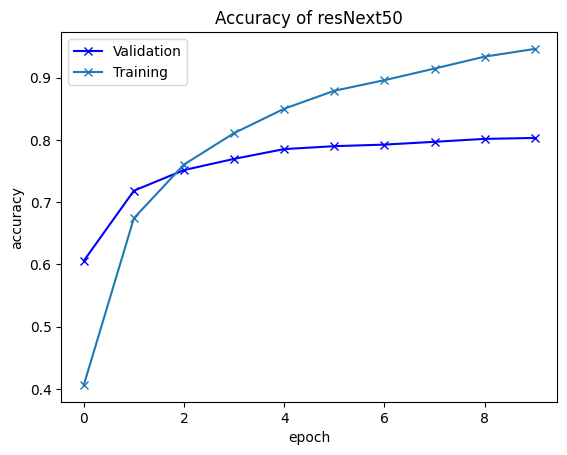

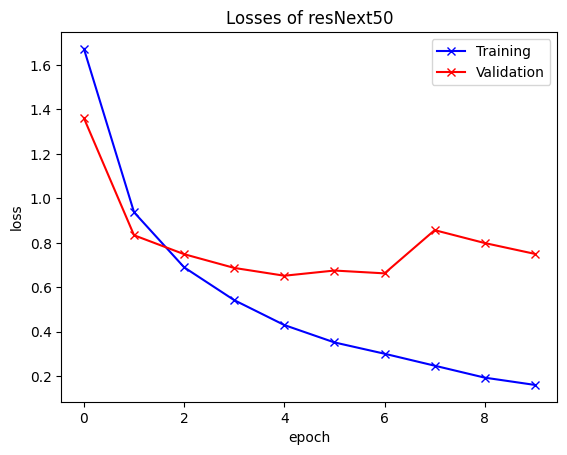

best acc in resNext50
{'val_loss': 0.750333309173584, 'val_acc': 0.8032000064849854}
CPU times: total: 2min 15s
Wall time: 3min 15s


In [987]:
%%time
history = fit_one_cycle(epochs, res_next50, trainloader, testloader, lr)

plot_accuracies(history, res_next50.name)
plt.show()
plot_losses(history, res_next50.name)
plt.show()

best_accurate_model = ResNext50(10)
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ res_next50.name +"_accuracy", weights_only = True))
print("best acc in " + res_next50.name)
print(evaluate(best_accurate_model, testloader))

MobileNet v2


Epoch [1], train_loss: 1.6928, train_acc: 0.4043, val_loss: 1.2747, val_acc: 0.5726
Epoch [2], train_loss: 1.1209, train_acc: 0.6116, val_loss: 0.9785, val_acc: 0.6617
Epoch [3], train_loss: 0.9146, train_acc: 0.6833, val_loss: 0.8503, val_acc: 0.7098
Epoch [4], train_loss: 0.7937, train_acc: 0.7260, val_loss: 0.7765, val_acc: 0.7338
Epoch [5], train_loss: 0.7106, train_acc: 0.7533, val_loss: 0.7320, val_acc: 0.7513
Epoch [6], train_loss: 0.6478, train_acc: 0.7746, val_loss: 0.6989, val_acc: 0.7594
Epoch [7], train_loss: 0.5942, train_acc: 0.7941, val_loss: 0.6739, val_acc: 0.7693
Epoch [8], train_loss: 0.5426, train_acc: 0.8111, val_loss: 0.6608, val_acc: 0.7742
Epoch [9], train_loss: 0.5043, train_acc: 0.8233, val_loss: 0.6496, val_acc: 0.7810
Epoch [10], train_loss: 0.4687, train_acc: 0.8358, val_loss: 0.6413, val_acc: 0.7883


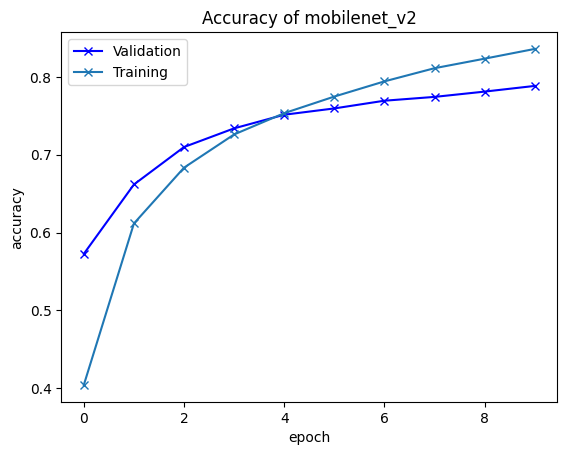

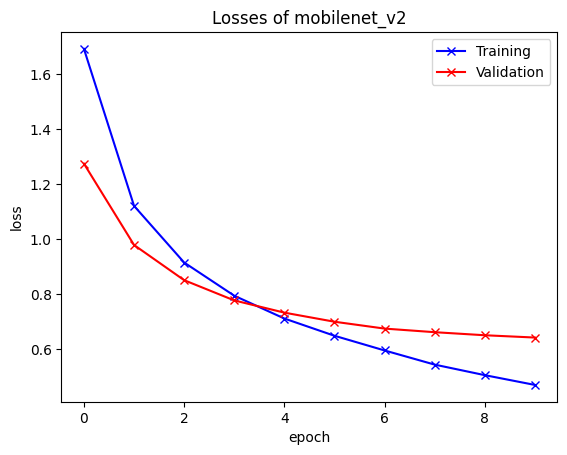

best acc in mobilenet_v2
{'val_loss': 0.6412588357925415, 'val_acc': 0.7883000373840332}
CPU times: total: 1min 33s
Wall time: 2min 33s


In [988]:
%%time
history = fit_one_cycle(epochs, mobile_net, trainloader, testloader, lr)

plot_accuracies(history, mobile_net.name)
plt.show()
plot_losses(history, mobile_net.name)
plt.show()

best_accurate_model = MobileNetV2(10)
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ mobile_net.name +"_accuracy", weights_only = True))
print("best acc in " + mobile_net.name)
print(evaluate(best_accurate_model, testloader))

ShuffleNet v2

In [989]:
epochs = 20

Epoch [1], train_loss: 2.2912, train_acc: 0.1503, val_loss: 2.2747, val_acc: 0.2264
Epoch [2], train_loss: 2.2486, train_acc: 0.2820, val_loss: 2.2141, val_acc: 0.3314
Epoch [3], train_loss: 2.1620, train_acc: 0.3607, val_loss: 2.0987, val_acc: 0.3939
Epoch [4], train_loss: 2.0210, train_acc: 0.4098, val_loss: 1.9512, val_acc: 0.4304
Epoch [5], train_loss: 1.8636, train_acc: 0.4452, val_loss: 1.7832, val_acc: 0.4657
Epoch [6], train_loss: 1.6773, train_acc: 0.4802, val_loss: 1.5833, val_acc: 0.5032
Epoch [7], train_loss: 1.4559, train_acc: 0.5219, val_loss: 1.3568, val_acc: 0.5552
Epoch [8], train_loss: 1.2645, train_acc: 0.5778, val_loss: 1.2040, val_acc: 0.6017
Epoch [9], train_loss: 1.1302, train_acc: 0.6255, val_loss: 1.0895, val_acc: 0.6313
Epoch [10], train_loss: 1.0243, train_acc: 0.6582, val_loss: 1.0060, val_acc: 0.6539
Epoch [11], train_loss: 0.9430, train_acc: 0.6844, val_loss: 0.9485, val_acc: 0.6712
Epoch [12], train_loss: 0.8777, train_acc: 0.7041, val_loss: 0.9035, val_a

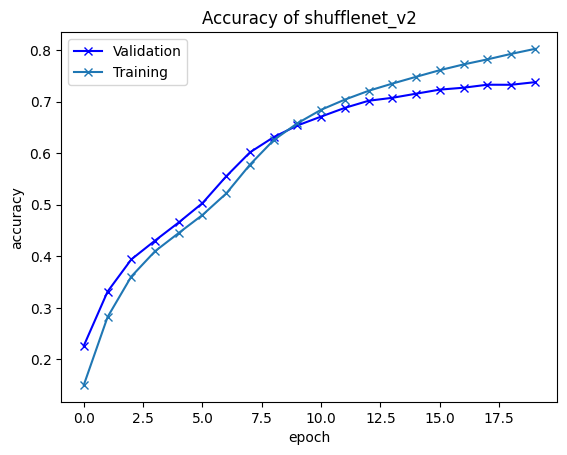

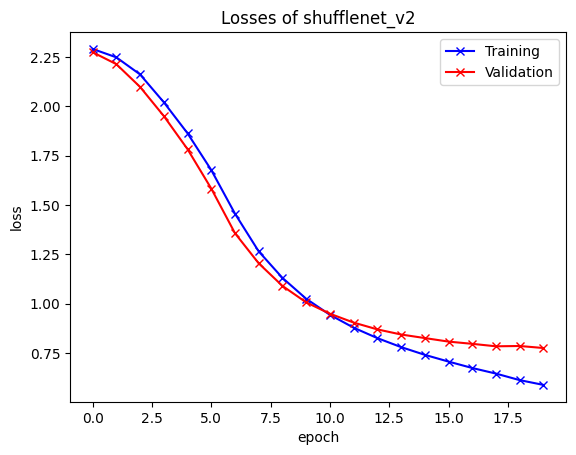

best acc in shufflenet_v2
{'val_loss': 0.7744234204292297, 'val_acc': 0.7379000186920166}
CPU times: total: 3min 26s
Wall time: 5min 23s


In [990]:
%%time
history = fit_one_cycle(epochs, shuffle_net, trainloader, testloader, lr)

plot_accuracies(history, shuffle_net.name)
plt.show()
plot_losses(history, shuffle_net.name)
plt.show()

best_accurate_model = ShuffleNetV2(10)
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ shuffle_net.name +"_accuracy", weights_only = True))
print("best acc in " + shuffle_net.name)
print(evaluate(best_accurate_model, testloader))

AlexNet

Epoch [1], train_loss: 2.3024, train_acc: 0.1010, val_loss: 2.3019, val_acc: 0.1597
Epoch [2], train_loss: 2.3017, train_acc: 0.1162, val_loss: 2.3006, val_acc: 0.1935
Epoch [3], train_loss: 2.2999, train_acc: 0.1218, val_loss: 2.2966, val_acc: 0.1403
Epoch [4], train_loss: 2.2896, train_acc: 0.1193, val_loss: 2.2601, val_acc: 0.1544
Epoch [5], train_loss: 2.1364, train_acc: 0.2109, val_loss: 1.9772, val_acc: 0.2704
Epoch [6], train_loss: 1.9090, train_acc: 0.2947, val_loss: 1.7748, val_acc: 0.3415
Epoch [7], train_loss: 1.7385, train_acc: 0.3500, val_loss: 1.6478, val_acc: 0.3892
Epoch [8], train_loss: 1.6471, train_acc: 0.3866, val_loss: 1.5859, val_acc: 0.4103
Epoch [9], train_loss: 1.5823, train_acc: 0.4135, val_loss: 1.5211, val_acc: 0.4375
Epoch [10], train_loss: 1.5245, train_acc: 0.4369, val_loss: 1.5178, val_acc: 0.4439
Epoch [11], train_loss: 1.4693, train_acc: 0.4607, val_loss: 1.3957, val_acc: 0.4854
Epoch [12], train_loss: 1.4038, train_acc: 0.4838, val_loss: 1.3387, val_a

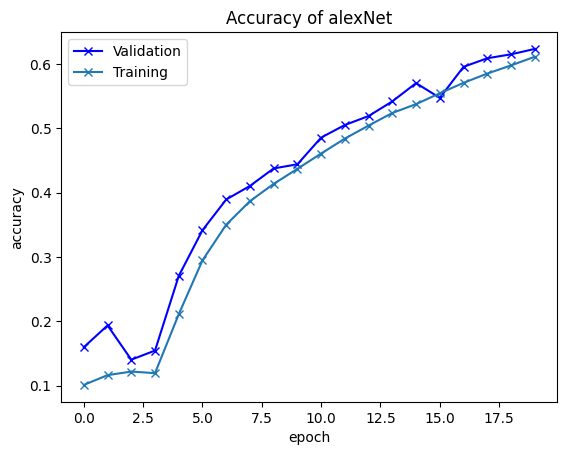

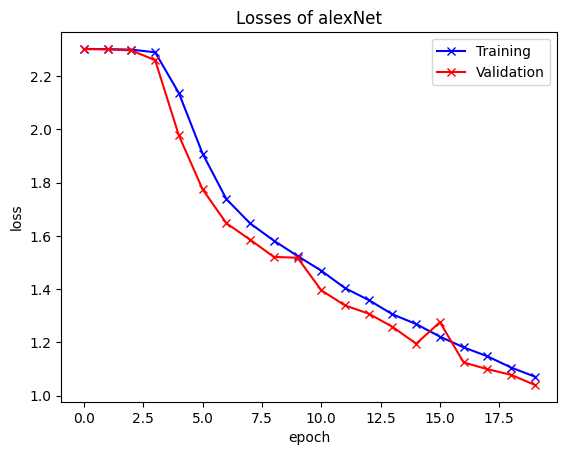

best acc in alexNet
{'val_loss': 1.04008150100708, 'val_acc': 0.6231999397277832}
CPU times: total: 3min 9s
Wall time: 5min 30s


In [991]:
%%time
history = fit_one_cycle(epochs, alex_net, trainloader, testloader, lr)

plot_accuracies(history, alex_net.name)
plt.show()
plot_losses(history, alex_net.name)
plt.show()

best_accurate_model = ImageClassificationBase(AlexNet(10), "AlexNet")
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ alex_net.name +"_accuracy", weights_only = True))
print("best acc in " + alex_net.name)
print(evaluate(best_accurate_model, testloader))

Тестируем модели с модификациями

In [992]:
alex_net_mod = ImageClassificationBase(AlexNet(), "alexNet")
res_next50_mod = ResNext50Mods(10)
mobile_net_mod = MobileNetV2Mods(10)
shuffle_net_mod = ShuffleNetV2Mods(10)

Epoch [1], train_loss: 2.0801, train_acc: 0.2763, val_loss: 2.5387, val_acc: 0.3697
Epoch [2], train_loss: 1.8803, train_acc: 0.3715, val_loss: 3.1381, val_acc: 0.4002
Epoch [3], train_loss: 1.7998, train_acc: 0.4004, val_loss: 2.7317, val_acc: 0.4161
Epoch [4], train_loss: 1.7580, train_acc: 0.4112, val_loss: 3.0586, val_acc: 0.4243
Epoch [5], train_loss: 1.7296, train_acc: 0.4215, val_loss: 3.6215, val_acc: 0.4296
Epoch [6], train_loss: 1.7008, train_acc: 0.4276, val_loss: 2.1242, val_acc: 0.4399
Epoch [7], train_loss: 1.6903, train_acc: 0.4283, val_loss: 3.6354, val_acc: 0.4401
Epoch [8], train_loss: 1.6756, train_acc: 0.4350, val_loss: 2.3209, val_acc: 0.4420
Epoch [9], train_loss: 1.6688, train_acc: 0.4375, val_loss: 2.8498, val_acc: 0.4403
Epoch [10], train_loss: 1.6590, train_acc: 0.4383, val_loss: 3.5685, val_acc: 0.4483
Epoch [11], train_loss: 1.6473, train_acc: 0.4425, val_loss: 6.5410, val_acc: 0.4438
Epoch [12], train_loss: 1.6384, train_acc: 0.4430, val_loss: 3.8807, val_a

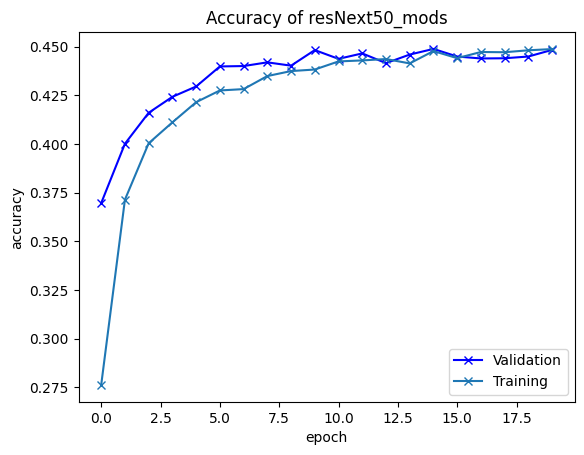

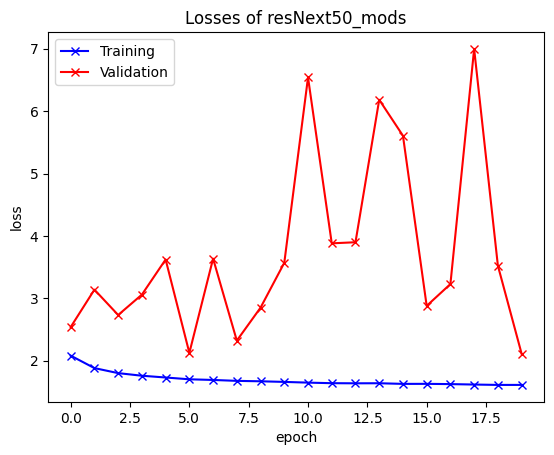

best acc in resNext50_mods
{'val_loss': 5.60631799697876, 'val_acc': 0.448900043964386}
CPU times: total: 2min 41s
Wall time: 4min 39s


In [993]:
%%time
history = fit_one_cycle(epochs, res_next50_mod, trainloader, testloader, lr)

plot_accuracies(history, res_next50_mod.name)
plt.show()
plot_losses(history, res_next50_mod.name)
plt.show()

best_accurate_model = ResNext50Mods(10)
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ res_next50_mod.name +"_accuracy", weights_only = True))
print("best acc in " + res_next50_mod.name)
print(evaluate(best_accurate_model, testloader))

Epoch [1], train_loss: 1.9458, train_acc: 0.3106, val_loss: 1.7713, val_acc: 0.3794
Epoch [2], train_loss: 1.8449, train_acc: 0.3400, val_loss: 1.7838, val_acc: 0.3664
Epoch [3], train_loss: 1.8119, train_acc: 0.3497, val_loss: 1.7258, val_acc: 0.3811
Epoch [4], train_loss: 1.7469, train_acc: 0.3725, val_loss: 1.6950, val_acc: 0.3920
Epoch [5], train_loss: 1.7085, train_acc: 0.3847, val_loss: 1.6523, val_acc: 0.4117
Epoch [6], train_loss: 1.7737, train_acc: 0.3647, val_loss: 1.7711, val_acc: 0.3571
Epoch [7], train_loss: 1.7684, train_acc: 0.3631, val_loss: 1.6892, val_acc: 0.3879
Epoch [8], train_loss: 1.7241, train_acc: 0.3800, val_loss: 1.6805, val_acc: 0.3980
Epoch [9], train_loss: 1.6917, train_acc: 0.3889, val_loss: 1.6567, val_acc: 0.4030
Epoch [10], train_loss: 1.6960, train_acc: 0.3897, val_loss: 1.6676, val_acc: 0.3947
Epoch [11], train_loss: 1.6770, train_acc: 0.3931, val_loss: 1.6491, val_acc: 0.4099
Epoch [12], train_loss: 1.6660, train_acc: 0.3960, val_loss: 1.6195, val_a

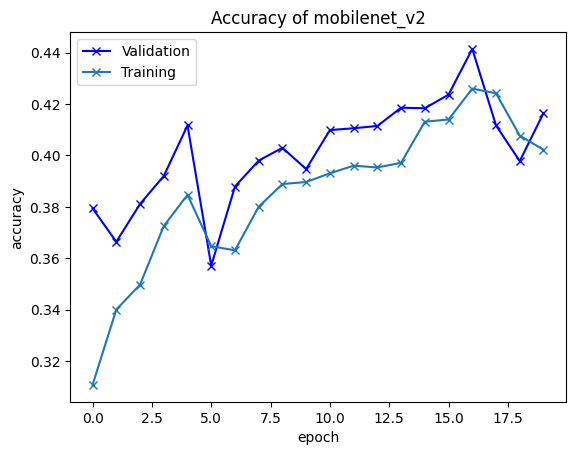

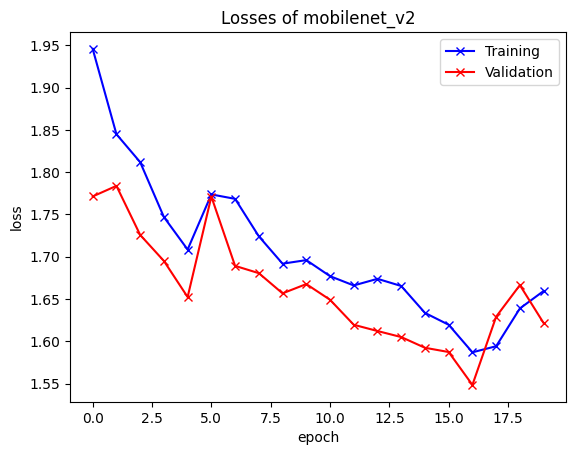

best acc in mobilenet_v2
{'val_loss': 1.548329472541809, 'val_acc': 0.4415000081062317}
CPU times: total: 2min 58s
Wall time: 5min 8s


In [994]:
%%time
history = fit_one_cycle(epochs, mobile_net_mod, trainloader, testloader, lr)

plot_accuracies(history, mobile_net_mod.name)
plt.show()
plot_losses(history, mobile_net_mod.name)
plt.show()

best_accurate_model = MobileNetV2Mods(10)
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ mobile_net_mod.name +"_accuracy", weights_only = True))
print("best acc in " + mobile_net_mod.name)
print(evaluate(best_accurate_model, testloader))

Epoch [1], train_loss: 2.2893, train_acc: 0.1664, val_loss: 2.2762, val_acc: 0.2340
Epoch [2], train_loss: 2.2650, train_acc: 0.2702, val_loss: 2.2541, val_acc: 0.2991
Epoch [3], train_loss: 2.2423, train_acc: 0.3258, val_loss: 2.2358, val_acc: 0.3368
Epoch [4], train_loss: 2.2216, train_acc: 0.3449, val_loss: 2.2142, val_acc: 0.3535
Epoch [5], train_loss: 2.2025, train_acc: 0.3547, val_loss: 2.1924, val_acc: 0.3670
Epoch [6], train_loss: 2.1838, train_acc: 0.3636, val_loss: 2.1788, val_acc: 0.3693
Epoch [7], train_loss: 2.1673, train_acc: 0.3711, val_loss: 2.1587, val_acc: 0.3739
Epoch [8], train_loss: 2.1508, train_acc: 0.3727, val_loss: 2.1441, val_acc: 0.3766
Epoch [9], train_loss: 2.1356, train_acc: 0.3753, val_loss: 2.1292, val_acc: 0.3815
Epoch [10], train_loss: 2.1215, train_acc: 0.3805, val_loss: 2.1183, val_acc: 0.3842
Epoch [11], train_loss: 2.1081, train_acc: 0.3813, val_loss: 2.1079, val_acc: 0.3797
Epoch [12], train_loss: 2.0948, train_acc: 0.3835, val_loss: 2.0923, val_a

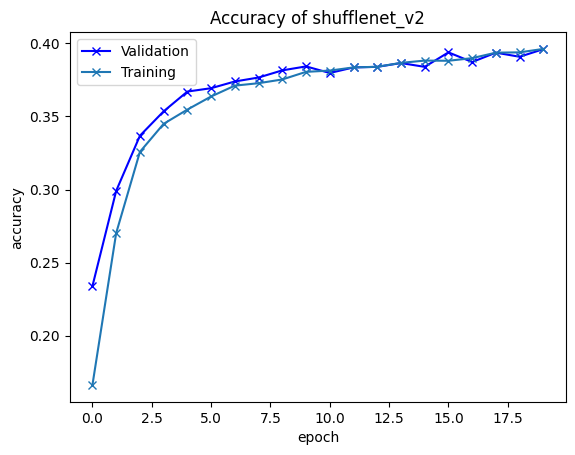

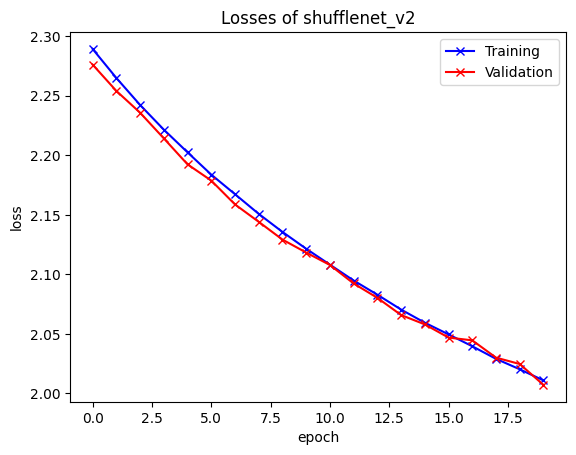

best acc in shufflenet_v2
{'val_loss': 2.0071184635162354, 'val_acc': 0.3959999978542328}
CPU times: total: 2min 26s
Wall time: 4min 33s


In [995]:
%%time
history = fit_one_cycle(epochs, shuffle_net_mod, trainloader, testloader, lr)

plot_accuracies(history, shuffle_net_mod.name)
plt.show()
plot_losses(history, shuffle_net_mod.name)
plt.show()

best_accurate_model = ShuffleNetV2Mods(10)
best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ shuffle_net_mod.name +"_accuracy", weights_only = True))
print("best acc in " + shuffle_net_mod.name)
print(evaluate(best_accurate_model, testloader))